In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from astroML.plotting import hist
from astroML.plotting.mcmc import plot_mcmc
from astroML.plotting import setup_text_plots
import pymc
setup_text_plots(fontsize=8, usetex=True)

%matplotlib inline

### Generate the Burst Data with a Gaussian Profile

In [2]:
### Modeled after AstroML book figure 10.25

# Define the function from which to generate the data
def GaussAndBkgd(t, b0, A, sigW, T):
    """Gaussian profile + flat background model"""
    y = np.empty(t.shape)
    y.fill(b0)
    y += A * np.exp(-(t - T)**2/2/sigW**2)
    return y

# Set a fixed random seed
np.random.seed(42)

# Choose the number of data points
N = 101

# Choose the true initial parameters
b0_true = 10
A_true = 3
sigma_true = 3.0
T_true = 40
err0_y = 0.5

# Add noise and calculate the "observed" flux values
t_obs = 100 * np.random.random(N)
y_true = GaussAndBkgd(t_obs, b0_true, A_true, sigma_true, T_true)
err_y = 0.5*np.sqrt(y_true/10) +np.random.uniform(0, 2*err0_y)
y_obs = np.random.normal(y_true, err_y) # Observed flux values

### Now run MCMC on the data assuming a Gaussian burst profile

In [4]:
# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
log_sigma = pymc.Uniform('log_sigma', -2, 2, value=0.1)


# uniform prior on log(alpha)
@pymc.deterministic
def sigma(log_sigma=log_sigma):
    return np.exp(log_sigma)


@pymc.deterministic
def y_model(t=t_obs, b0=b0, A=A, sigma=sigma, T=T):
    return GaussAndBkgd(t, b0, A, sigma, T)

y = pymc.Normal('y', mu=y_model, tau=err_y ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_sigma=log_sigma, sigma=sigma, y_model=y_model, y=y)

#----------------------------------------------------------------------
# Run the MCMC sampling
#@pickle_results('matchedfilt_gauss.pkl')
def compute_Gaussian_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'sigma']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.sigma.value, M.T.value)

    return traces, fit_vals

# Save the traces and best-fit values for the Gaussian profile
Gaussian_traces, Gaussian_fit_vals = compute_Gaussian_MCMC_results()

 [-----------------100%-----------------] 25000 of 25000 complete in 5.2 sec

### Run MCMC on the data assuming an exponential burst profile

In [25]:
# Define the exponential burst profile
def burst(t, b0, A, alpha, T):
    """Burst model"""
    y = np.empty(t.shape)
    y.fill(b0)
    mask = (t >= T)
    y[mask] += A * np.exp(-alpha * (t[mask] - T))
    return y


# Set up MCMC sampling
b0 = pymc.Uniform('b0', 0, 50, value=50 * np.random.random())
A = pymc.Uniform('A', 0, 50, value=50 * np.random.random())
T = pymc.Uniform('T', 0, 100, value=100 * np.random.random())
log_alpha = pymc.Uniform('log_alpha', -10, 10, value=0)


# uniform prior on log(alpha)
@pymc.deterministic
def alpha(log_alpha=log_alpha):
    return np.exp(log_alpha)


@pymc.deterministic
def y_model(t=t_obs, b0=b0, A=A, alpha=alpha, T=T):
    return burst(t, b0, A, alpha, T)

y = pymc.Normal('y', mu=y_model, tau=sigma ** -2, observed=True, value=y_obs)

model = dict(b0=b0, A=A, T=T, log_alpha=log_alpha,
             alpha=alpha, y_model=y_model, y=y)

# Run the MCMC sampling
def compute_Exponential_MCMC_results(niter=25000, burn=4000):
    S = pymc.MCMC(model)
    S.sample(iter=niter, burn=burn)
    traces = [S.trace(s)[:] for s in ['b0', 'A', 'T', 'alpha']]

    M = pymc.MAP(model)
    M.fit()
    fit_vals = (M.b0.value, M.A.value, M.alpha.value, M.T.value)

    return traces, fit_vals

# Save the traces and best-fit values for the exponential profile
Exponential_traces, Exponential_fit_vals = compute_Exponential_MCMC_results()

 [-----------------100%-----------------] 25000 of 25000 complete in 4.5 sec

### Plot the data and best-fit models

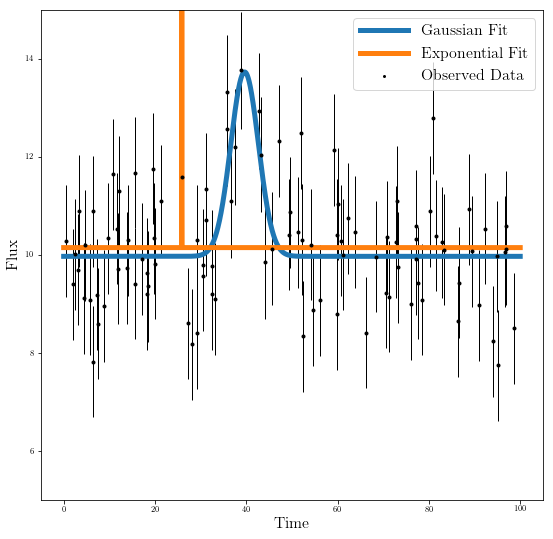

In [30]:
# Plot the initial data and two models
plt.figure(figsize=[9,9])

# We need a very fine grid in t for the models because the exponential profile can be very peaked
t = np.linspace(0,100,10001)
Gauss_y_fit = GaussAndBkgd(t, *Gaussian_fit_vals)
Exp_y_fit = burst(t, *Exponential_fit_vals)

# Plot the data with errors
plt.scatter(t_obs, y_obs, s=9, lw=0, c='k')
plt.errorbar(t_obs, y_obs, err_y, fmt='.', lw=1, c='k')

# Plot the Gaussian fit
plt.plot(t,Gauss_y_fit,lw=5)

# Plot the exponential fit
plt.plot(t,Exp_y_fit,lw=5)

# Set limits, labels, and legend
plt.ylim([5,15])
plt.xlabel('Time',fontsize=16)
plt.ylabel('Flux',fontsize=16)
plt.legend(['Gaussian Fit','Exponential Fit','Observed Data'],fontsize=16)

In [ ]:
ChiSq = np.sum()